## Bayesian methods of hyperparameter optimization

In addition to the random search and the grid search methods for selecting optimal hyperparameters, we can use Bayesian methods of probabilities to select the optimal hyperparameters for an algorithm.

In this case study, we will be using the BayesianOptimization library to perform hyperparmater tuning. This library has very good documentation which you can find here: https://github.com/fmfn/BayesianOptimization

You will need to install the Bayesian optimization module. Running a cell with an exclamation point in the beginning of the command will run it as a shell command — please do this to install this module from our notebook in the cell below.

In [39]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [41]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [42]:
import lightgbm

In [43]:
from catboost import CatBoostClassifier, cv, Pool

In [44]:
import os
os.listdir()

['.DS_Store',
 'flight_delays_test.csv',
 'flight_delays_train.csv',
 'Unit 18.2.6_Bayesian_Optimization_Case_Study.ipynb',
 '.ipynb_checkpoints']

## How does Bayesian optimization work?

Bayesian optimization works by constructing a posterior distribution of functions (Gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

<img src="https://github.com/fmfn/BayesianOptimization/blob/master/examples/bo_example.png?raw=true" />
As you iterate over and over, the algorithm balances its needs of exploration and exploitation while taking into account what it knows about the target function. At each step, a Gaussian Process is fitted to the known samples (points previously explored), and the posterior distribution, combined with an exploration strategy (such as UCB — aka Upper Confidence Bound), or EI (Expected Improvement). This process is used to determine the next point that should be explored (see the gif below).
<img src="https://github.com/fmfn/BayesianOptimization/raw/master/examples/bayesian_optimization.gif" />

## Let's look at a simple example

The first step is to create an optimizer. It uses two items:
* function to optimize
* bounds of parameters

The function is the procedure that counts metrics of our model quality. The important thing is that our optimization will maximize the value on function. Smaller metrics are best. Hint: don't forget to use negative metric values.

Here we define our simple function we want to optimize.

In [45]:
def simple_func(a, b):
    return a + b

Now, we define our bounds of the parameters to optimize, within the Bayesian optimizer.

In [46]:
optimizer = BayesianOptimization(
    f=simple_func,
    pbounds={'a': (1, 3),'b': (4, 7)},
    allow_duplicate_points=True)     # a is between 1 to 3, b is between 4 and 7, find out maximize a+b.

In [47]:
optimizer

These are the main parameters of this function:

* **n_iter:** This is how many steps of Bayesian optimization you want to perform. The more steps, the more likely you are to find a good maximum.

* **init_points:** This is how many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

Let's run an example where we use the optimizer to find the best values to maximize the target value for a and b given the inputs of 3 and 2.

In [48]:
optimizer.maximize(init_points=10, n_iter=2)

|   iter    |  target   |     a     |     b     |
-------------------------------------------------
| 1         | 7.34      | 2.136     | 5.204     |
| 2         | 7.735     | 1.284     | 6.451     |
| 3         | 5.83      | 1.679     | 4.151     |
| 4         | 6.955     | 2.701     | 4.254     |
| 5         | 9.596     | 2.66      | 6.936     |
| 6         | 6.532     | 1.468     | 5.064     |
| 7         | 6.612     | 1.582     | 5.03      |
| 8         | 5.398     | 1.22      | 4.178     |
| 9         | 8.941     | 2.067     | 6.874     |
| 10        | 7.524     | 2.558     | 4.966     |
| 11        | 10.0      | 3.0       | 7.0       |
Data point [3. 7.] is not unique. 1 duplicates registered. Continuing ...
| 12        | 10.0      | 3.0       | 7.0       |


Great, now let's print the best parameters and the associated maximized target.

In [49]:
print(optimizer.max['params']);optimizer.max['target']

{'a': 3.0, 'b': 7.0}


10.0

## Test it on real data using the Light GBM

The dataset we will be working with is the famous flight departures dataset. Our modeling goal will be to predict if a flight departure is going to be delayed by 15 minutes based on the other attributes in our dataset. As part of this modeling exercise, we will use Bayesian hyperparameter optimization to identify the best parameters for our model.

**<font color='teal'> You can load the zipped csv files just as you would regular csv files using Pandas read_csv. In the next cell load the train and test data into two seperate dataframes. </font>**


In [50]:
train_df = pd.read_csv('flight_delays_train.csv')
test_df = pd.read_csv('flight_delays_test.csv')

**<font color='teal'> Print the top five rows of the train dataframe and review the columns in the data. </font>**

In [51]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [52]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


**<font color='teal'> Use the describe function to review the numeric columns in the train dataframe. </font>**

In [53]:
train_df.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


Notice, `DepTime` is the departure time in a numeric representation in 24 hours format. But some `DepTime` looks strange, i.e. large than 2400.

First, let's check the minutes in `DepTime`.

In [54]:
DepTime = train_df['DepTime'].unique()
DepTime_min = [int(str(time)[-2:]) for time in DepTime]
sum(np.array(DepTime_min)>=60)

0

Looks like all 'DepTime' minutes are less than 60. Good, let's check hours

In [55]:
sum(np.array(DepTime)>2400)

16

In [56]:
train_df[train_df.DepTime > 2400].head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
8189,c-6,c-14,c-2,2435,EV,CVG,AVL,275,Y
20766,c-5,c-31,c-2,2534,EV,ATL,HSV,151,Y
27391,c-3,c-23,c-4,2505,EV,ATL,AGS,143,Y
44332,c-7,c-15,c-5,2440,EV,ATL,SHV,552,Y
45796,c-8,c-18,c-4,2447,EV,ATL,JAN,341,Y


There are 16 rows with DepTime have hour large than 24. Drop them.

In [57]:
train_df = train_df[train_df.DepTime <= 2400].copy()

In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99983 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Month              99983 non-null  object
 1   DayofMonth         99983 non-null  object
 2   DayOfWeek          99983 non-null  object
 3   DepTime            99983 non-null  int64 
 4   UniqueCarrier      99983 non-null  object
 5   Origin             99983 non-null  object
 6   Dest               99983 non-null  object
 7   Distance           99983 non-null  int64 
 8   dep_delayed_15min  99983 non-null  object
dtypes: int64(2), object(7)
memory usage: 7.6+ MB


 **<font color='teal'>The response variable is 'dep_delayed_15min' which is a categorical column, so we need to map the Y for yes and N for no values to 1 and 0. Run the code in the next cell to do this.</font>**

In [59]:
train_df['dep_delayed_15min'] = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

In [60]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1


## Feature Engineering
Use these defined functions to create additional features for the model. Run the cell to add the functions to your workspace.

In [61]:
def label_enc(df_column):
    df_column = LabelEncoder().fit_transform(df_column)
    return df_column

def make_harmonic_features_sin(value, period=2400):
    value *= 2 * np.pi / period 
    return np.sin(value)

def make_harmonic_features_cos(value, period=2400):
    value *= 2 * np.pi / period 
    return np.cos(value)

def feature_eng(df):
    df['flight'] = df['Origin']+df['Dest']
    df['Month'] = df.Month.map(lambda x: x.split('-')[-1]).astype('int32')
    df['DayofMonth'] = df.DayofMonth.map(lambda x: x.split('-')[-1]).astype('uint8')             
    df['begin_of_month'] = (df['DayofMonth'] < 10).astype('uint8')                               # use astype('uint8') change True/False to 1/0
    df['midddle_of_month'] = ((df['DayofMonth'] >= 10)&(df['DayofMonth'] < 20)).astype('uint8')  # use astype('uint8') change True/False to 1/0     
    df['end_of_month'] = (df['DayofMonth'] >= 20).astype('uint8')                                # use astype('uint8') change True/False to 1/0
    df['DayOfWeek'] = df.DayOfWeek.map(lambda x: x.split('-')[-1]).astype('uint8')
    df['hour'] = df.DepTime.map(lambda x: x/100).astype('int32')
    df['morning'] = df['hour'].map(lambda x: 1 if (x <= 11)& (x >= 7) else 0).astype('uint8')
    df['day'] = df['hour'].map(lambda x: 1 if (x >= 12) & (x <= 18) else 0).astype('uint8')
    df['evening'] = df['hour'].map(lambda x: 1 if (x >= 19) & (x <= 23) else 0).astype('uint8')
    df['night'] = df['hour'].map(lambda x: 1 if (x >= 0) & (x <= 6) else 0).astype('int32')
    df['winter'] = df['Month'].map(lambda x: x in [12, 1, 2]).astype('int32')                    # use astype('int32') change True/False to 1/0         
    df['spring'] = df['Month'].map(lambda x: x in [3, 4, 5]).astype('int32')                     # use astype('int32') change True/False to 1/0 
    df['summer'] = df['Month'].map(lambda x: x in [6, 7, 8]).astype('int32')                     # use astype('int32') change True/False to 1/0 
    df['autumn'] = df['Month'].map(lambda x: x in [9, 10, 11]).astype('int32')                   # use astype('int32') change True/False to 1/0 
    df['holiday'] = (df['DayOfWeek'] >= 5).astype(int)                 # use astype(int) change True/False to 1/0 
    df['weekday'] = (df['DayOfWeek'] < 5).astype(int)                  # use astype(int) change True/False to 1/0 
    df['airport_dest_per_month'] = df.groupby(['Dest', 'Month'])['Dest'].transform('count')
    df['airport_origin_per_month'] = df.groupby(['Origin', 'Month'])['Origin'].transform('count')
    df['airport_dest_count'] = df.groupby(['Dest'])['Dest'].transform('count')
    df['airport_origin_count'] = df.groupby(['Origin'])['Origin'].transform('count')
    df['carrier_count'] = df.groupby(['UniqueCarrier'])['Dest'].transform('count')
    df['carrier_count_per month'] = df.groupby(['UniqueCarrier', 'Month'])['Dest'].transform('count')
    df['deptime_cos'] = df['DepTime'].map(make_harmonic_features_cos)
    df['deptime_sin'] = df['DepTime'].map(make_harmonic_features_sin)
    df['flightUC'] = df['flight']+df['UniqueCarrier']
    df['DestUC'] = df['Dest']+df['UniqueCarrier']
    df['OriginUC'] = df['Origin']+df['UniqueCarrier']
    return df.drop('DepTime', axis=1)

Concatenate the training and testing dataframes.


In [62]:
full_df = pd.concat([train_df, test_df])
full_df = feature_eng(full_df)

In [63]:
full_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight,begin_of_month,midddle_of_month,end_of_month,hour,morning,day,evening,night,winter,spring,summer,autumn,holiday,weekday,airport_dest_per_month,airport_origin_per_month,airport_dest_count,airport_origin_count,carrier_count,carrier_count_per month,deptime_cos,deptime_sin,flightUC,DestUC,OriginUC
0,8,21,7,AA,ATL,DFW,732,0.0,ATLDFW,0,0,1,19,0,0,1,0,0,0,1,0,1,0,746,1016,8290,11375,18024,1569,0.343660,-0.939094,ATLDFWAA,DFWAA,ATLAA
1,4,20,3,US,PIT,MCO,834,0.0,PITMCO,0,0,1,15,0,1,0,0,0,1,0,0,0,1,313,105,3523,1390,13069,1094,-0.612907,-0.790155,PITMCOUS,MCOUS,PITUS
2,9,2,5,XE,RDU,CLE,416,0.0,RDUCLE,1,0,0,14,0,1,0,0,0,0,0,1,1,0,166,136,2246,1747,11737,977,-0.835807,-0.549023,RDUCLEXE,CLEXE,RDUXE
3,11,25,6,OO,DEN,MEM,872,0.0,DENMEM,0,0,1,10,1,0,0,0,0,0,0,1,1,0,136,514,1785,6222,15343,1242,-0.884988,0.465615,DENMEMOO,MEMOO,DENOO
4,10,7,6,WN,MDW,OMA,423,1.0,MDWOMA,1,0,0,18,0,1,0,0,0,0,0,1,1,0,48,226,687,2571,30958,2674,0.073238,-0.997314,MDWOMAWN,OMAWN,MDWWN


In [64]:
full_df.isna().sum()

Month                            0
DayofMonth                       0
DayOfWeek                        0
UniqueCarrier                    0
Origin                           0
Dest                             0
Distance                         0
dep_delayed_15min           100000
flight                           0
begin_of_month                   0
midddle_of_month                 0
end_of_month                     0
hour                             0
morning                          0
day                              0
evening                          0
night                            0
winter                           0
spring                           0
summer                           0
autumn                           0
holiday                          0
weekday                          0
airport_dest_per_month           0
airport_origin_per_month         0
airport_dest_count               0
airport_origin_count             0
carrier_count                    0
carrier_count_per mo

Apply the earlier defined feature engineering functions to the full dataframe.

In [65]:
for column in ['UniqueCarrier', 'Origin', 'Dest','flight',  'flightUC', 'DestUC', 'OriginUC']:
    full_df[column] = label_enc(full_df[column])

In [66]:
full_df.head()      # now  full_df is all numeric df

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight,begin_of_month,midddle_of_month,end_of_month,hour,morning,day,evening,night,winter,spring,summer,autumn,holiday,weekday,airport_dest_per_month,airport_origin_per_month,airport_dest_count,airport_origin_count,carrier_count,carrier_count_per month,deptime_cos,deptime_sin,flightUC,DestUC,OriginUC
0,8,21,7,1,19,82,732,0.0,171,0,0,1,19,0,0,1,0,0,0,1,0,1,0,746,1016,8290,11375,18024,1569,0.343660,-0.939094,265,494,67
1,4,20,3,19,226,180,834,0.0,3986,0,0,1,15,0,1,0,0,0,1,0,0,0,1,313,105,3523,1390,13069,1094,-0.612907,-0.790155,6907,1085,1441
2,9,2,5,21,239,62,416,0.0,4091,1,0,0,14,0,1,0,0,0,0,0,1,1,0,166,136,2246,1747,11737,977,-0.835807,-0.549023,7064,359,1518
3,11,25,6,16,81,184,872,0.0,1304,0,0,1,10,1,0,0,0,0,0,0,1,1,0,136,514,1785,6222,15343,1242,-0.884988,0.465615,2258,1122,484
4,10,7,6,20,182,210,423,1.0,2979,1,0,0,18,0,1,0,0,0,0,0,1,1,0,48,226,687,2571,30958,2674,0.073238,-0.997314,5144,1313,1103


In [67]:
full_df.nunique()

Month                         12
DayofMonth                    31
DayOfWeek                      7
UniqueCarrier                 23
Origin                       307
Dest                         307
Distance                    1390
dep_delayed_15min              2
flight                      5048
begin_of_month                 2
midddle_of_month               2
end_of_month                   2
hour                          25
morning                        2
day                            2
evening                        2
night                          2
winter                         2
spring                         2
summer                         2
autumn                         2
holiday                        2
weekday                        2
airport_dest_per_month       396
airport_origin_per_month     388
airport_dest_count           228
airport_origin_count         221
carrier_count                 23
carrier_count_per month      248
deptime_cos                 1316
deptime_si


Split the new full dataframe into X_train and X_test. 

In [68]:
train_df_new = full_df[:train_df.shape[0]]
test_df_new= full_df[train_df.shape[0]:]

In [69]:
train_df_new.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight,begin_of_month,midddle_of_month,end_of_month,hour,morning,day,evening,night,winter,spring,summer,autumn,holiday,weekday,airport_dest_per_month,airport_origin_per_month,airport_dest_count,airport_origin_count,carrier_count,carrier_count_per month,deptime_cos,deptime_sin,flightUC,DestUC,OriginUC
0,8,21,7,1,19,82,732,0.0,171,0,0,1,19,0,0,1,0,0,0,1,0,1,0,746,1016,8290,11375,18024,1569,0.343660,-0.939094,265,494,67
1,4,20,3,19,226,180,834,0.0,3986,0,0,1,15,0,1,0,0,0,1,0,0,0,1,313,105,3523,1390,13069,1094,-0.612907,-0.790155,6907,1085,1441
2,9,2,5,21,239,62,416,0.0,4091,1,0,0,14,0,1,0,0,0,0,0,1,1,0,166,136,2246,1747,11737,977,-0.835807,-0.549023,7064,359,1518
3,11,25,6,16,81,184,872,0.0,1304,0,0,1,10,1,0,0,0,0,0,0,1,1,0,136,514,1785,6222,15343,1242,-0.884988,0.465615,2258,1122,484
4,10,7,6,20,182,210,423,1.0,2979,1,0,0,18,0,1,0,0,0,0,0,1,1,0,48,226,687,2571,30958,2674,0.073238,-0.997314,5144,1313,1103


In [70]:
test_df_new.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight,begin_of_month,midddle_of_month,end_of_month,hour,morning,day,evening,night,winter,spring,summer,autumn,holiday,weekday,airport_dest_per_month,airport_origin_per_month,airport_dest_count,airport_origin_count,carrier_count,carrier_count_per month,deptime_cos,deptime_sin,flightUC,DestUC,OriginUC
0,7,25,3,22,198,222,598,NaN,3228,0,0,1,6,0,0,0,1,0,0,1,0,0,1,446,22,5571,221,6029,518,-0.039260,0.999229,5514,1432,1190
1,4,17,2,20,159,132,1235,NaN,2523,0,1,0,7,1,0,0,0,0,1,0,0,0,1,130,427,1513,4932,30958,2578,-0.355923,0.934515,4285,766,950
2,12,2,7,13,122,213,577,NaN,1955,1,0,0,6,0,0,0,1,1,0,0,0,1,0,805,27,9877,339,14424,1194,-0.133121,0.991100,3307,1340,714
3,3,25,7,20,49,188,377,NaN,694,0,0,1,16,0,1,0,0,0,1,0,0,1,0,41,253,571,3029,30958,2570,-0.467930,-0.883766,1183,1145,287
4,6,6,3,18,213,276,258,NaN,3697,1,0,0,15,0,1,0,0,0,0,1,0,0,1,158,849,1763,9823,13311,1125,-0.697790,-0.716302,6348,1829,1331


Create a list of the categorical features.

In [71]:
categorical_features = ['UniqueCarrier', 'Origin', 'Dest','flight',  'flightUC', 'DestUC', 'OriginUC']

Let's build a light GBM model to test the bayesian optimizer.

### [LightGBM](https://lightgbm.readthedocs.io/en/latest/) is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

First, we define the function we want to maximize and that will count cross-validation metrics of lightGBM for our parameters.

Some params such as num_leaves, max_depth, min_child_samples, min_data_in_leaf should be integers.

In [72]:
from sklearn.model_selection import train_test_split

X = train_df_new.drop('dep_delayed_15min', axis=1)
y = train_df_new['dep_delayed_15min']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

In [73]:
lgtrain = lightgbm.Dataset(X_train, y_train, categorical_feature=categorical_features, free_raw_data=False)

In [74]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "num_threads" : 20,
        "min_child_samples" : int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : 0.03,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "feature_pre_filter": False}
    
    cv_result = lightgbm.cv(params=params,
                       train_set=lgtrain,
                       num_boost_round=1000,
                       stratified=True,
                       nfold=3)
    return cv_result['valid auc-mean'][-1]  

<font color=red> why use [-1] to return the last one, is it always the maximum value????

<font color=red> the min_child_samples and min_data_in_leaf are same parameter. this is strange to repeated used.
https://lightgbm.readthedocs.io/en/stable/Parameters.html

Apply the Bayesian optimizer to the function we created in the previous step to identify the best hyperparameters. We will run 10 iterations and set init_points = 2.


In [75]:
lgbBO = BayesianOptimization(f=lgb_eval, pbounds={'num_leaves': (25, 4000),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 0.05),
                                                'lambda_l1': (0.0, 0.05),
                                                'min_child_samples': (50, 10000),
                                                'min_data_in_leaf': (100, 2000)})

In [76]:
lgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
| 1         | 0.733     | 0.04892   | 0.02947   | 22.78     | 5.682e+03 | 1.104e+03 | 2.024e+03 |
| 2         | 0.7367    | 0.03834   | 0.03857   | 20.32     | 4.986e+03 | 1.897e+03 | 2.497e+03 |
| 3         | 0.7362    | 0.009514  | 0.03317   | 12.08     | 3.672e+03 | 1.249e+03 | 563.6     |
| 4         | 0.7328    | 0.0471    | 0.04525   | 33.99     | 4.898e+03 | 1.164e+03 | 2.608e+03 |
| 5         | 0.7365    | 0.03901   | 0.01233   | 47.95     | 7.984e+03 | 1.958e+03 | 629.4     |
| 6         | 0.7369    | 0.02775   | 0.03885   | 17.19     | 2.776e+03 | 1.832e+03 | 2.226e+03 |
| 7         | 0.7082    | 0.002291  | 0.04103   | 15.92     | 396.9     | 662.4     | 3.162e+03 |
| 8         | 0.736     | 0.006403  | 0.03412   | 42.17     | 9.939e+03 | 1.966e+03 | 3.742e+03 |
| 9         | 0.6957

 **<font color='teal'> Print all results by using the '.res' function.</font>**

In [138]:
lgbBO.res

[{'target': 0.7330266537410289,
  'params': {'lambda_l1': 0.04891530752643454,
   'lambda_l2': 0.029473984130791882,
   'max_depth': 22.777287383073425,
   'min_child_samples': 5682.150347777244,
   'min_data_in_leaf': 1104.2086876528122,
   'num_leaves': 2023.6132526178753}},
 {'target': 0.7367443315041556,
  'params': {'lambda_l1': 0.03834170685414082,
   'lambda_l2': 0.03857073808367794,
   'max_depth': 20.321473898765646,
   'min_child_samples': 4985.820806354555,
   'min_data_in_leaf': 1897.4957093441706,
   'num_leaves': 2496.9959167012175}},
 {'target': 0.7361744072607529,
  'params': {'lambda_l1': 0.009513691901295246,
   'lambda_l2': 0.033166235151974435,
   'max_depth': 12.084540778811856,
   'min_child_samples': 3672.4428527439445,
   'min_data_in_leaf': 1248.93915839465,
   'num_leaves': 563.6347350575212}},
 {'target': 0.7327689834051059,
  'params': {'lambda_l1': 0.047104349510963456,
   'lambda_l2': 0.04525422879480952,
   'max_depth': 33.99482936770164,
   'min_child_sa

 **<font color='teal'> Print the best result by using the '.max' function.</font>**

In [80]:
lgbBO.max

{'target': 0.7369473908252746,
 'params': {'lambda_l1': 0.02774976553924449,
  'lambda_l2': 0.03884635036275905,
  'max_depth': 17.191792483278753,
  'min_child_samples': 2775.6558710962963,
  'min_data_in_leaf': 1831.602834072356,
  'num_leaves': 2225.829374770909}}

Review the process at each step by using the '.res[0]' function.

 **<font color='teal'> Use the parameters get from hypertuning.</font>**

In [115]:
params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_leaves" : int(2225.829374770909),
        "max_depth" : int(17.191792483278753),
        "lambda_l2" : 0.03884635036275905,
        "lambda_l1" : 0.02774976553924449,
        "num_threads" : 20,
        "min_child_samples" : int(2775.6558710962963),
        'min_data_in_leaf': int(1831.602834072356),
        "learning_rate" : 0.03,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "feature_pre_filter": False}

lgb = lightgbm.train(params=params, train_set=lgtrain)

In [116]:
y_valid_predict_probs = lgb.predict(X_valid)
y_valid_predict_probs

array([0.42926376, 0.57363526, 0.36084969, ..., 0.61635873, 0.25015125,
       0.46527856])

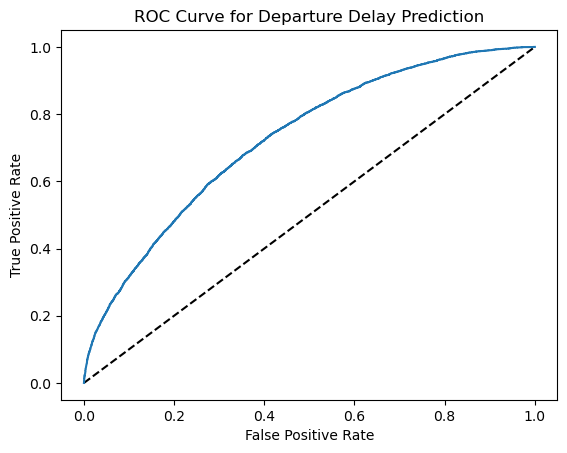

In [117]:
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_predict_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Departure Delay Prediction')
plt.show()

 **<font color='red'> Use threshold=0.5 for following analysis. Note that for this imbalanced dataset, 0.5 maybe not a good choice!!.</font>**

In [118]:
y_valid_predict = (y_valid_predict_probs > 0.5).astype('int')

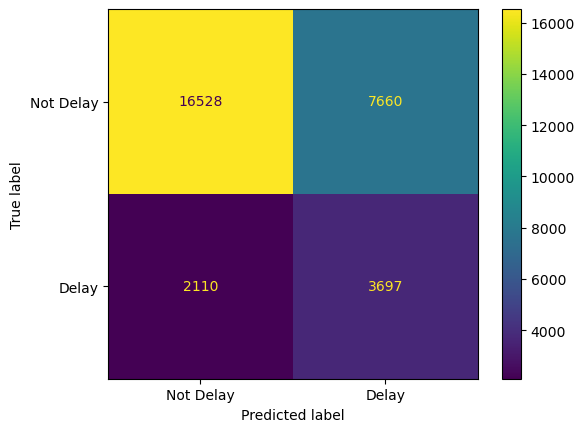

In [119]:
cm = confusion_matrix(y_valid, y_valid_predict, labels = np.array([0,1]))

_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Not Delay', 'Delay'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Not Delay', 'Delay'], fontsize = 10)
ax.set_yticklabels(labels = ['Not Delay', 'Delay'], fontsize = 10)
display_cm.plot(ax = ax)

In [120]:
print(classification_report(y_valid, y_valid_predict))

              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77     24188
         1.0       0.33      0.64      0.43      5807

    accuracy                           0.67     29995
   macro avg       0.61      0.66      0.60     29995
weighted avg       0.78      0.67      0.71     29995



 **<font color='teal'> Let's play around and try something different.</font>**

In [87]:
def lgb_eval(num_iterations, learning_rate, num_leaves, max_depth,lambda_l2,lambda_l1, min_child_weight, bagging_fraction, feature_fraction):
    params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_iterations" : int(num_iterations),
        "learning_rate" : learning_rate,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "min_child_weight" : int(min_child_weight),
        "bagging_fraction" : bagging_fraction,
        "feature_fraction" : feature_fraction,
        "verbosity" : -1,
        "bagging_seed" : 42,
        }
    
    cv_result = lightgbm.cv(params=params,
                       train_set=lgtrain,
                       num_boost_round=1000,
                       stratified=True,
                       nfold=3)
    return cv_result['valid auc-mean'][-1]  

In [88]:
lgbBO_2 = BayesianOptimization(f=lgb_eval, pbounds={'num_iterations': (50,1000),
                                                  'learning_rate': (0.01,0.3),
                                                  'num_leaves': (20, 150),
                                                  'max_depth': (3, 15),
                                                  'lambda_l2': (0.0, 1),
                                                  'lambda_l1': (0.0, 1),
                                                  'min_child_weight': (1,10),
                                                  'bagging_fraction': (0.5, 1),
                                                  'feature_fraction': (0.5, 1)})

In [89]:
lgbBO_2.maximize(n_iter=10, init_points=2)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_it... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6945    | 0.8169    | 0.6898    | 0.7885    | 0.8357    | 0.06374   | 11.77     | 7.165     | 631.7     | 43.37     |
| 2         | 0.7021    | 0.928     | 0.5155    | 0.4076    | 0.7035    | 0.1551    | 12.0      | 8.403     | 320.8     | 117.8     |
| 3         | 0.7011    | 0.8621    | 0.5128    | 0.6775    | 0.8643    | 0.2341    | 14.85     | 8.316     | 322.1     | 116.3     |
| 4         | 0.6971    | 0.5384    | 0.7261    | 0.9099    | 0.8179    | 0.2264    | 4.073     | 4.664     | 307.4     | 130.1     |
| 5         | 0.699     | 0.5605    | 0.9757    | 0.2808    | 0.3322    | 0.1503    | 4.287     | 5.093     | 323.3     | 111.5     |
| 6         | 0.6985    | 0.8409    | 0.5806    | 0.1284    | 

In [90]:
lgbBO_2.max

{'target': 0.7142096032338298,
 'params': {'bagging_fraction': 0.9521008161429096,
  'feature_fraction': 0.6805835609163842,
  'lambda_l1': 0.8559388227339425,
  'lambda_l2': 0.8611871686364946,
  'learning_rate': 0.0214313703851424,
  'max_depth': 11.1323095319407,
  'min_child_weight': 7.612355632912223,
  'num_iterations': 322.0138683166364,
  'num_leaves': 117.27343888015048}}

In [123]:
params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_iterations" : int(322.0138683166364),
        "learning_rate" : 0.0214313703851424,
        "num_leaves" : int(117.27343888015048),
        "max_depth" : int(11.1323095319407),
        "lambda_l2" : 0.8611871686364946,
        "lambda_l1" : 0.8559388227339425,
        "min_child_weight" : int(7.612355632912223),
        "bagging_fraction" : 0.9521008161429096,
        "feature_fraction" : 0.6805835609163842,
        "verbosity" : -1,
        "bagging_seed" : 42,
        }

In [124]:
lgb_2 = lightgbm.train(params=params, train_set=lgtrain)

In [125]:
y_valid_predict_probs_2 = lgb_2.predict(X_valid)
y_valid_predict_probs_2

array([0.40325097, 0.48132955, 0.38486515, ..., 0.6881065 , 0.26820522,
       0.42061018])

In [139]:
y_valid_predict_2 = (y_valid_predict_probs_2 > 0.5).astype('int')

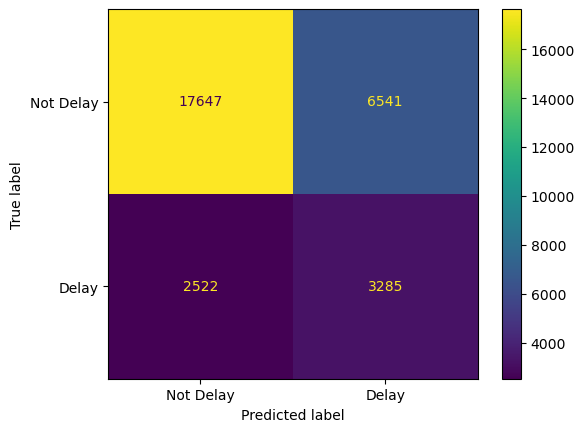

In [140]:
cm = confusion_matrix(y_valid, y_valid_predict_2, labels = np.array([0,1]))

_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Not Delay', 'Delay'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Not Delay', 'Delay'], fontsize = 10)
ax.set_yticklabels(labels = ['Not Delay', 'Delay'], fontsize = 10)
display_cm.plot(ax = ax)

In [141]:
print(classification_report(y_valid, y_valid_predict_2))

              precision    recall  f1-score   support

         0.0       0.87      0.73      0.80     24188
         1.0       0.33      0.57      0.42      5807

    accuracy                           0.70     29995
   macro avg       0.60      0.65      0.61     29995
weighted avg       0.77      0.70      0.72     29995



 **<font color='red'> It looks like the first parameter set give higher auc score 0.7369 than the second one 0.7142, but on the valid set, the second one performs better, accuracy 0.70 better than first one's 0.67. This is really surprising.</font>**